In [50]:
# Need this environment to be as simple as can be. 1 auv, then 1 auv + 1 asv. Then 2 auvs + 1 asv. Then 2 auvs + 2 asvs.

from pathlib import Path
import os
import yaml
import numpy as np
from influence_moo.config import load_config
from influence_moo.waves import sample_waves
from influence_moo.plotting import plot_grid, plot_pts, plot_vectors

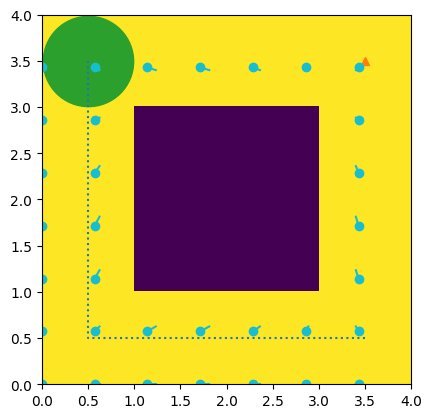

In [53]:
# Map
cg = np.ones((4,4))
cg[1:-1, 1:-1] = 0

# pois
pois = [
    {
        'position': [0.5, 3.5],
        'observation_radius': 1.0,
        'value': 1.0
    }
]

# auvs
auvs = [
    {
        'path': [
            [3.5, 0.5],
            [0.5, 0.5],
            [0.5, 3.5]
        ],
    }
]

# asvs
asvs = [
    {
        'position': [3.5, 3.5]
    }
]

x_a = 0.1
x_b = 1.0
x_c = 0.0

def wave_x(x):
    return x_a * np.sin(x/x_b + x_c)

y_a = 0.1
y_b = 1.0
y_c = 0.0

def wave_y(y):
    return y_a * np.sin(y/y_b+y_c)

vec = sample_waves(cg, 8, 8, wave_x, wave_y)

# Timing and kinematic constraints
dt = 1
t_final = 20
asv_max_speed = 1.0
auv_max_speed = 0.3

# Neural Network
hidden = [10]

# Observation parameters
observation_type = 'local'
num_asv_bins = 4
num_auv_bins = 4
num_obstacle_traces = 4

# CCEA params
subpopulation_size = 30
n_elites = 5

plot_pts(np.array([pois[0]['position']]), None, '.', markersize=130, color='tab:green')
plot_pts(np.array(auvs[0]['path']), None, ':')
plot_pts(np.array([asvs[0]['position']]), None, '^')
plot_vectors(vec, color='tab:cyan')
plot_grid(cg)

In [60]:
# Take in a config and modify it so that it has these parameters
# Then replicate it for all the methods

cdir = Path(os.path.expanduser('~/influence-multi-objective/results/simple_a/config_start.yaml'))
for method in ['D-Indirect-Step', 'D-Indirect-Traj', 'D', 'G', 'Fitness Critic', 'Alignment']:
    # Load the starter config
    c = load_config(cdir)

    # Add in all the parameters that are method-agnostic
    # -- Connectivity Grid
    c['env']['connectivity_grid'] = cg.astype(int).tolist()

    # -- AUVs
    c['env']['auvs'] = auvs

    # -- ASVs
    c['env']['asvs'] = asvs

    # -- pois
    c['env']['pois'] = pois

    # -- waves
    c['env']['waves']['x_']['a'] = x_a
    c['env']['waves']['x_']['b'] = x_b
    c['env']['waves']['x_']['c'] = x_c
    c['env']['waves']['y_']['a'] = y_a
    c['env']['waves']['y_']['b'] = y_b
    c['env']['waves']['y_']['c'] = y_c

    # -- Timing
    c['env']['dt'] = dt
    c['env']['t_final'] = t_final
    c['env']['asv_params']['max_speed'] = asv_max_speed
    c['env']['auv_params']['max_speed'] = auv_max_speed

    # -- Neural Network
    c['env']['asv_params']['network']['num_hidden'] = hidden

    # -- Observations
    c['env']['asv_params']['observation_type'] = observation_type
    c['env']['asv_params']['num_asv_bins'] = num_asv_bins
    c['env']['asv_params']['num_auv_bins'] = num_auv_bins
    c['env']['asv_params']['num_obstacle_traces'] = num_obstacle_traces

    # -- CCEA
    c['ccea']['subpopulation_size'] = subpopulation_size
    c['ccea']['selection']['n_elites_binary_tournament']['n_elites'] = n_elites

    # Add specific parameters for specific method
    if method == 'D-Indirect-Step':
        c['rewards']['asv_reward'] = 'indirect_difference_team'
        c['rewards']['influence_type'] = 'granular'
        c['rewards']['which_critic'] = 'none'
    elif method == 'D-Indirect-Traj':
        c['rewards']['asv_rewards'] = 'indirect_difference_team'
        c['rewards']['influence_type'] = 'all_or_nothing'
        c['rewards']['which_critic'] = 'none'
    elif method == 'D':
        c['rewards']['asv_rewards'] = 'difference'
        c['rewards']['influence_type'] = 'all_or_nothing'
        c['rewards']['which_critic'] = 'none'
    elif method == 'G':
        c['rewards']['asv_rewards'] = 'global'
        c['rewards']['influence_type'] = 'all_or_nothing'
        c['rewards']['which_critic'] = 'none'
    elif method == 'Fitness Critic':
        c['rewards']['asv_rewards'] = 'global'
        c['rewards']['influence_type'] = 'all_or_nothing'
        c['rewards']['which_critic'] = 'fitness_critic'
    elif method == 'Alignment':
        c['rewards']['asv_rewards'] = 'global'
        c['rewards']['influence_type'] = 'all_or_nothing'
        c['rewards']['which_critic'] = 'alignment'

    # Save the new config

    # -- New directory
    nf = cdir.parent / method
    os.makedirs(nf, exist_ok = True)

    # -- Save it
    with open(nf / 'config.yaml', 'w') as file:
        yaml.dump(c, file, default_flow_style=False)


In [ ]:
#